# Data Exploration

แหล่งข้อมูล: https://ieeexplore.ieee.org/document/1300799
https://www.ahajournals.org/doi/10.1161/01.CIR.101.23.e215

guide: https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg

The dataset contains 64-channel EEG recordings from 109 subjects and 14 runs on each subject in EDF+ format. The recordings were made using the BCI2000 system. To load a subject, do:

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors


from mne import Epochs, pick_types, events_from_annotations, find_events
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.viz import plot_montage, plot_compare_evokeds
from mne.datasets import eegbci
from mne.time_frequency import tfr_morlet

ลองดูข้อมูลจาก subject คนแรก

In [3]:
 # กำหนดค่าพารามิเตอร์สำหรับโหลดชุดข้อมูลที่เราสนใจ โดยมีรายละเอียดเพิ่มเติมจาก link นี้ https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html#mne.datasets.eegbci.load_data
tmin, tmax = -1.0, 4.0
subject = 1 # เลือก subject ที่เราสนใจ (ค่าตั้งแต่ 1 ถึง 109)
runs = [6, 10, 14]  # เลือกข้อมูล Motor imagery: hands vs feet 

# ทำการโหลดข้อมูล ด้วยพารามิเตอร์ที่เรากำหนดไว้ด้านบน
raw_fnames = eegbci.load_data(1, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

# print ข้อมูลเบื้องต้นของชุดข้อมูลออกมาดู
print(raw.info)
print(f"channels: {raw.info.ch_names}")

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
channels:

เราลองมาดูคร่าว ๆ ว่าข้อมูลนี้ประกอบไปด้วยสัญญาณความถี่ใดบ้าง

Effective window size : 12.800 (s)


<ipython-input-4-13e9b45ab963>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=80).plot(picks="data", exclude="bads")


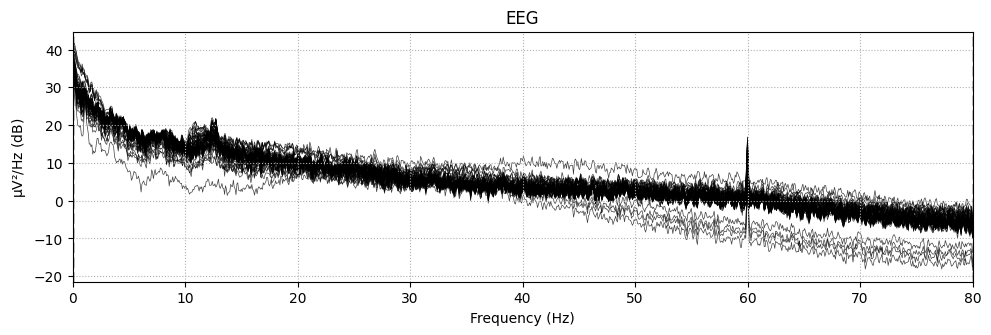

In [4]:
raw.compute_psd(fmax=80).plot(picks="data", exclude="bads")

จะเห็นว่ามี peak อยู่ที่ 60 Hz ซึ่งน่าจะเป็น powerline noise ที่เราควรกำจัดออก

ในตัวอย่างนี้ สมมติว่าเราสนใจองค์ประกอบที่มีความถี่อยู่ระหว่าง 7 Hz ถึง 30 Hz เท่านั้น เราจึงเรียกใช้ `filter` เพื่อลดความสำคัญขององค์ประกอบที่มีความถี่นอกเหนือจากช่วง 7-30 Hz ไป

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Effective window size : 12.800 (s)


<ipython-input-5-24509512777e>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=80).plot(picks="data", exclude="bads")


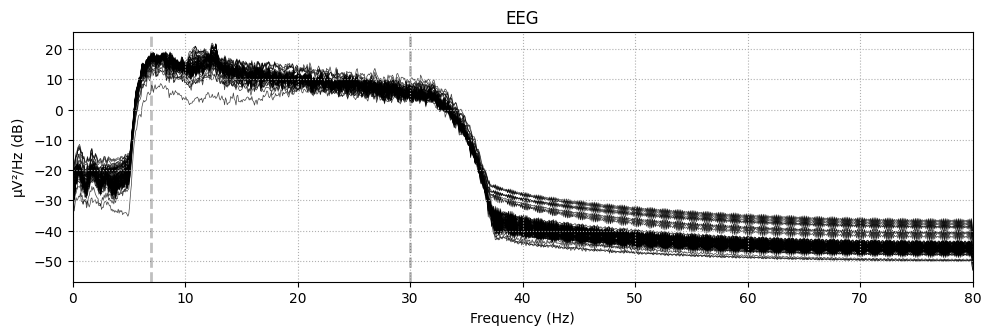

In [5]:
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")
raw.compute_psd(fmax=80).plot(picks="data", exclude="bads")

เห็นได้ว่าข้อมูลที่อยู่นอกช่วง 7-30 Hz มีค่าลดลงอย่างมาก รวมถึง powerline noise ที่ 60 Hz ก็ได้ถูกกำจัดออกไปผ่านกระบวนการ filtering

เรามาลอง plot ข้อมูลจาก electrodes 10 อัน โดยมีแกน x คือแกนเวลาดู

Using matplotlib as 2D backend.


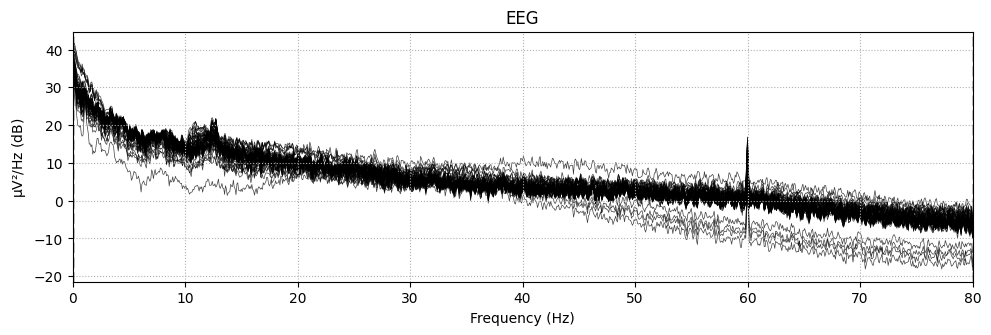

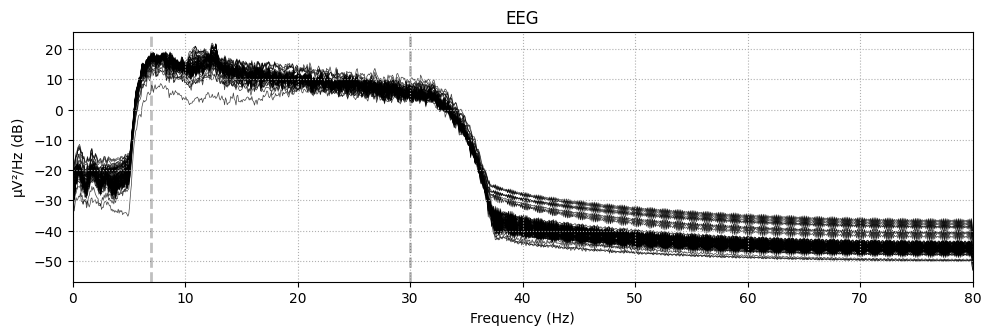

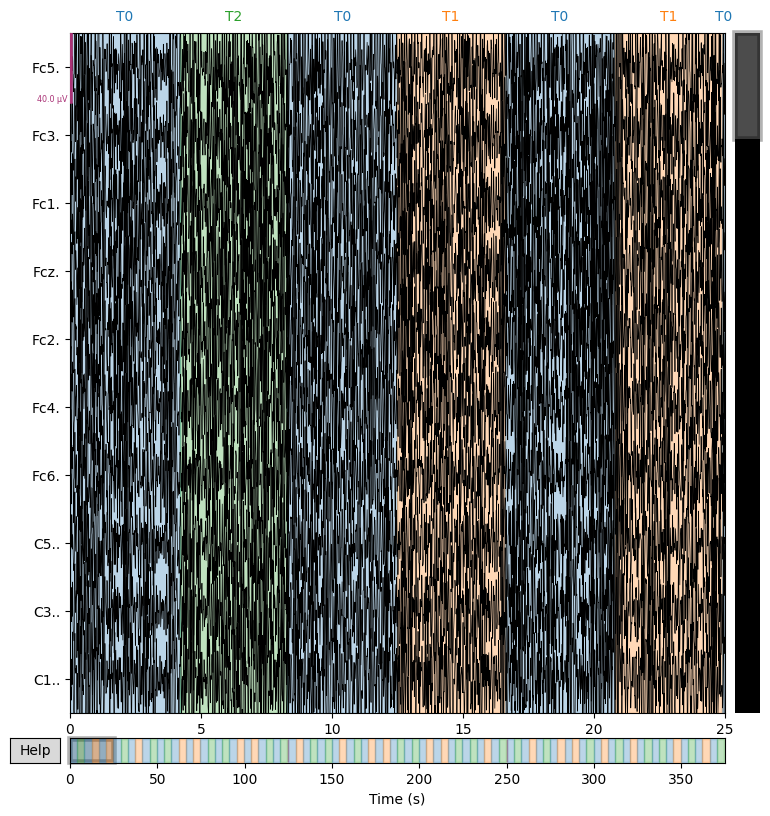

# of time points: 60000
Used Annotations descriptions: ['T0', 'T1', 'T2']
Existing event ID: {'T0': 1, 'T1': 2, 'T2': 3}


In [6]:
raw.plot(duration=25, n_channels=10)
print(f"# of time points: {raw.n_times}")

# ลองดูว่ามี event อะไรอยู่ในข้อมูลของเราบ้าง
_, event_id = events_from_annotations(raw, event_id=None)
print(f"Existing event ID: {event_id}")

แถบสีต่าง ๆ แสดงถึง event ที่ต่างกันในแต่ละช่วงเวลา เช่น สีส้ม (T1) แสดงถึงช่วงเวลาที่อาสาสมัครนึกภาพว่ากำลังเคลื่อนไหวมือ ส่วนสีเขียว (T2) คือช่วงเวลาที่เราให้อาสาสมัครนึกภาพว่ากำลังเคลื่อนไหวเท้า โดยที่โค้ดด้านบนซูมให้ดูแค่ทีละ 25 วินาที (หรือ ประมาณทีละ 6 events)

---

ขั้นตอนต่อไปเรียกว่าการทำ Epoch หรือการตัดข้อมูลของเรา ซึ่งตอนนี้อยู่ใน format ที่มีแกนเวลายาวมาก ๆ ออกเป็นชิ้นเล็ก ๆ และเก็บเอาไว้เฉพาะ events ที่เราสนใจ

ในที่นี้เราจะเก็บไว้เฉพาะ event สีส้ม (T1) และ event สีเขียว (T2)

In [7]:
hands_id, feet_id = 2, 3 # ตัวเลขนี้ถูกกำหนดมาจากชุดข้อมูลอยู่แล้ว (ไม่ต้องแก้)

# หาดูว่า events ไหนอยู่ที่เวลาใดบ้าง โดยเราสนใจแค่ event T1 และ T2
events, _ = events_from_annotations(raw, event_id=dict(T1=hands_id, T2=feet_id), verbose='WARNING')

# เปลี่ยนชื่อ event จาก T1 ไปเป็น hands และเปลี่ยนชื่อ event จาก T2 ไปเป็น feet เพื่อให้เข้าใจง่ายขึ้น
event_id = dict(hands=hands_id, feet=feet_id)

# เลือกเก็บเฉพาะข้อมูล EEG และกำจัดข้อมูล electrode ที่มีปัญหา
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# ทำการตัดข้อมูลออกเป็นส่วน ๆ และเก็บไว้เฉพาะ events ที่สนใจ
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
    verbose='WARNING'
)

print(f"Events of interest: {event_id}")

Events of interest: {'hands': 2, 'feet': 3}


ลองมาดูข้อมูลหลังจากที่ถูกตัดเป็นท่อน ๆ กัน โดยมี

*   แกน x เป็นแกนเวลา ของ time signal จากแต่ละ event (epoch)


*   มีเส้นประแสดงถึงบริเวณที่มี stimulus ขึ้นมาออกคำสั่งให้อาสาสมัครทำตาม event ที่กำหนดมา เช่น การเริ่มคิดภาพการขยับมือ ถ้าได้รับ event เป็น hands


*   แกน y เป็นแกน epoch แต่ละ row ในภาพแสดงถึง time signal 1 epoch ที่เวลาต่าง ๆ โดยแสดง magnitude ของข้อมูลเป็นสี (โทนสีแดงคือมีค่าบวกมาก และ โทนสีน้ำเงินคือมีค่าเป็นลบมาก)


*   ด้านล่างสุดแสดง time signal ที่เกิดจากการเอา time signal ทั้งหมดมาเฉลี่ยกัน


เริ่มต้นจากการดูข้อมูล hands event ก่อน



Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-8-e830b42118d1>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['hands'].plot_image(picks=[32])


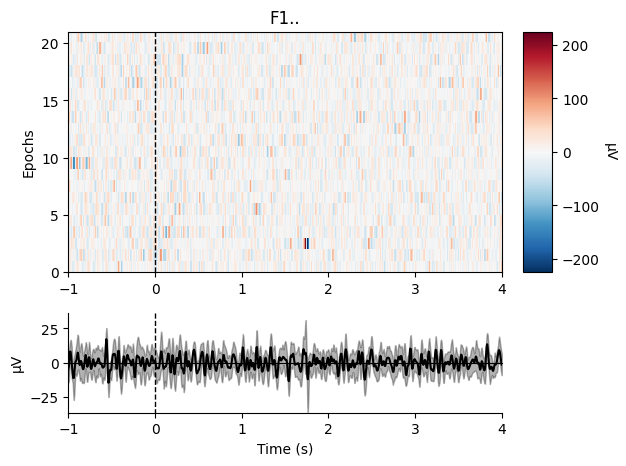

[<Figure size 640x480 with 3 Axes>]

In [8]:
epochs['hands'].plot_image(picks=[32])

ลองดูข้อมูลจาก feet event บ้าง

Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-9-3acadefa831f>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['feet'].plot_image(picks=[0])


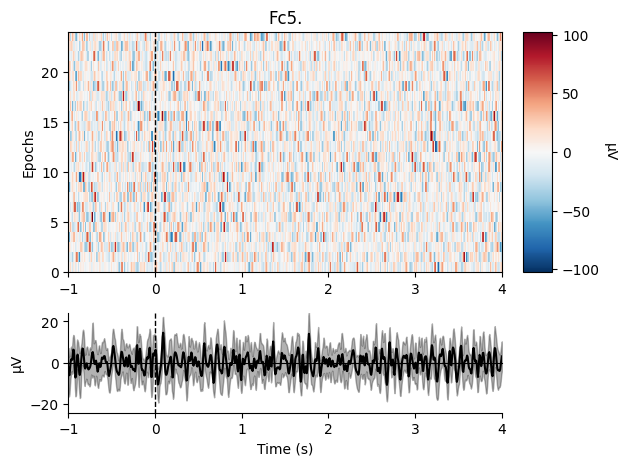

[<Figure size 640x480 with 3 Axes>]

In [9]:
epochs['feet'].plot_image(picks=[0])

In [10]:
# frequencies = np.arange(7, 30, 3)
# power = tfr_morlet(epochs['hands'], n_cycles=2, return_itc=False, freqs=frequencies, decim=3
# )
# # power.plot(["MEG 1332"])

In [11]:
hands_evoked = epochs['hands'].average()
feet_evoked = epochs['feet'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


combining channels using "gfp"
combining channels using "gfp"


<ipython-input-12-cf7ef59ecbcb>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_compare_evokeds(dict(hands=hands_evoked,


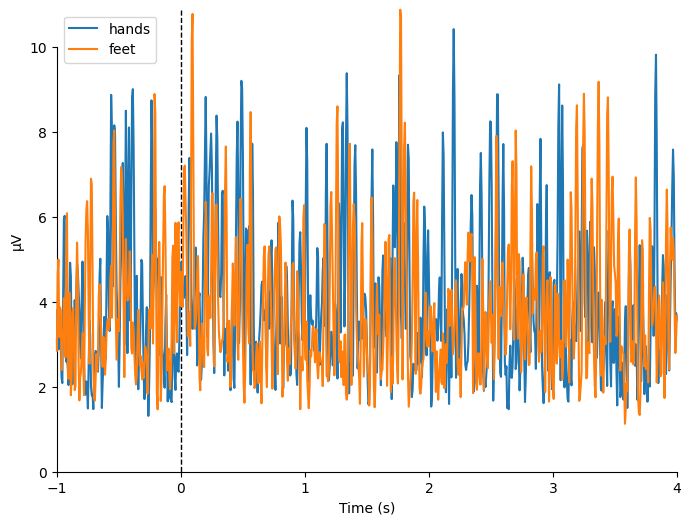

[<Figure size 800x600 with 1 Axes>]

In [12]:
plot_compare_evokeds(dict(hands=hands_evoked, 
                          feet=feet_evoked),
                     legend="upper left",
                     show_sensors="upper right",
)

In [13]:
# hands_evoked.plot_joint()
# feet_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

In [14]:
# evoked_diff = mne.combine_evoked([hands_evoked, feet_evoked], weights=[1, -1])
# evoked_diff.pick_types(meg="mag").plot_topo(color="r", legend=False)